# Teacher usando técnicas de transfer learning y fine tunning

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, imagenet_utils
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1,l2, l1_l2
# Clases
from utils import InspecTrain_img, Plot_training_performance 
from utils import  ModDataFrame, ObtenerEtiquetas

In [2]:
pathBase = "my_dataset/"          # Directorio de data
pathTrain=pathBase+'train/'       # Directorio de train
pathTeacher_img = "models/teacherModels/img/TL_FT"     # Directorio guardado de imagenes
pathTeacher_models = "models/teacherModels/models/"           # Directorio guardado de modelos
targetSize = (192,192)

In [3]:
# Leer data frame de train
df = pd.read_csv(pathBase + '/train.csv')        
df_train = ModDataFrame(df)
etiquetas = ObtenerEtiquetas(df_train)


Etiquetas de train
['costra', 'multiples_enfermedades', 'oxido', 'saludable']


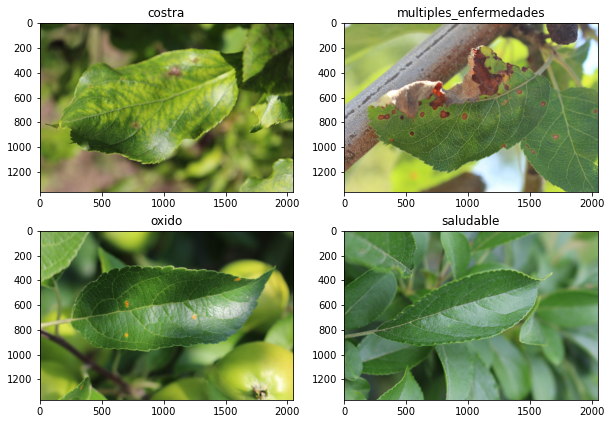

Numero de imagenes: 1821
Tamaño mínimo: [1365 1365]

Archivos por carpeta:

costra: 592
multiples_enfermedades: 91
oxido: 622
saludable: 516


In [4]:
# mostrar imagenes de ejemplo y obtener el numero de elementos
numImages, n_files = InspecTrain_img(etiquetas,pathTrain)

In [5]:
def Show_classification_report(model, test_x, test_y, batchSize_train):
        predictions = model.predict(test_x, batch_size=batchSize_train)
        pred = np.argmax(predictions, axis=1)
        test_y = np.argmax(test_y, axis=1)
        print(classification_report(test_y, pred, target_names=etiquetas))

In [6]:
BatchSize = numImages

# Usar preprocesamiento usado en imageNet
imageNet_trainGenerator = ImageDataGenerator(validation_split=0.2, preprocessing_function=preprocess_input) # VGG16 preprocessing

imageNet_trainGen = imageNet_trainGenerator.flow_from_directory(pathTrain, target_size=targetSize,
                                               class_mode='categorical', subset='training', classes=etiquetas,
                                               batch_size=BatchSize, shuffle=True, seed=42)

# Usar 20% para TEST (reservado hasta pruebas finales)
imageNet_testGen = imageNet_trainGenerator.flow_from_directory(pathTrain, target_size=targetSize,
                                               class_mode='categorical', subset='validation', classes=etiquetas,
                                               batch_size=BatchSize, shuffle=True, seed=42)

trainX, trainY = next(imageNet_trainGen)
testX, testY = next(imageNet_testGen)

# IMPORTANTE: Se normalizan los datos como se normalizaron en el entrenamiento con ImageNet!!
trainX = preprocess_input(trainX)
testX = preprocess_input(testX)

print(testX.shape)
print(trainX.shape)

Found 1458 images belonging to 4 classes.
Found 363 images belonging to 4 classes.
(363, 192, 192, 3)
(1458, 192, 192, 3)


## VGG16

In [7]:
VGG16_baseModel = VGG16(weights='imagenet',
                 include_top=False, # No incluir el top model, i.e. la parte densa destinada a la clasificación (fully connected layers)
                 input_shape=(192,192,3))

VGG16_baseModel.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 192, 192, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 192, 192, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 192, 192, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 96, 96, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 96, 96, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 96, 96, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 48, 48, 128)       0     

In [36]:
# Creando el top model y congelando TODAS las capas convolucionales (TRANSFER LEARNING)
VGG16_baseModel.trainable = False # Evitar que los pesos se modifiquen en la parte convolucional -> TRANSFER LEARNING
VGG16_preTrainedModel = Sequential()
VGG16_preTrainedModel.add(VGG16_baseModel)
VGG16_preTrainedModel.add(layers.Flatten())
# VGG16_preTrainedModel.add(layers.Dense(1024, activation='relu', kernel_regularizer=l2(0.01)))
VGG16_preTrainedModel.add(layers.Dense(1024, activation='relu', ))
VGG16_preTrainedModel.add(BatchNormalization())
VGG16_preTrainedModel.add(Dropout(0.3))  
# VGG16_preTrainedModel.add(layers.Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
VGG16_preTrainedModel.add(layers.Dense(512, activation='relu'))
VGG16_preTrainedModel.add(BatchNormalization())
VGG16_preTrainedModel.add(Dropout(0.3))  
VGG16_preTrainedModel.add(layers.Dense(4, activation='softmax'))
VGG16_preTrainedModel.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              18875392  
_________________________________________________________________
batch_normalization_12 (Batc (None, 1024)              4096      
_________________________________________________________________
dropout_12 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               524800    
_________________________________________________________________
batch_normalization_13 (Batc (None, 512)              

In [22]:
epochs=10

# Compilar el modelo
print("[INFO]: Compilando el modelo...")
VGG16_preTrainedModel.compile(loss="categorical_crossentropy", 
                          optimizer=Adam(learning_rate=0.001),
                          metrics=["accuracy"]) 

#Callbacks
model_cp = ModelCheckpoint(pathTeacher_models+"TL_FT/vgg16_TL_1.h5", monitor='val_loss', verbose=0, save_best_only=True, 
                           save_weights_only=False, mode='auto', save_freq='epoch')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, verbose=1)

callbacks_list = [model_cp, reduce_lr]  

# Entrenamiento de la red
print("[INFO]: Entrenando la red...")

H_preTrained_vgg16=VGG16_preTrainedModel.fit(trainX, trainY, epochs=epochs, batch_size=64,
                                             validation_split=0.2, callbacks=callbacks_list)

[INFO]: Compilando el modelo...
[INFO]: Entrenando la red...
Epoch 1/10
19/19 [==============================] - 56s 3s/step - loss: 1.1047 - accuracy: 0.6501 - val_loss: 2.3799 - val_accuracy: 0.7603
Epoch 2/10
19/19 [==============================] - 55s 3s/step - loss: 0.2452 - accuracy: 0.9151 - val_loss: 2.1345 - val_accuracy: 0.6986
Epoch 3/10
19/19 [==============================] - 56s 3s/step - loss: 0.0933 - accuracy: 0.9691 - val_loss: 1.1764 - val_accuracy: 0.7877
Epoch 4/10
19/19 [==============================] - 58s 3s/step - loss: 0.0319 - accuracy: 0.9923 - val_loss: 1.2134 - val_accuracy: 0.7740
Epoch 5/10
19/19 [==============================] - 56s 3s/step - loss: 0.0279 - accuracy: 0.9940 - val_loss: 0.9829 - val_accuracy: 0.7842
Epoch 6/10
19/19 [==============================] - 55s 3s/step - loss: 0.0127 - accuracy: 0.9966 - val_loss: 0.9594 - val_accuracy: 0.7842
Epoch 7/10
19/19 [==============================] - 56s 3s/step - loss: 0.0102 - accuracy: 0.9974 -

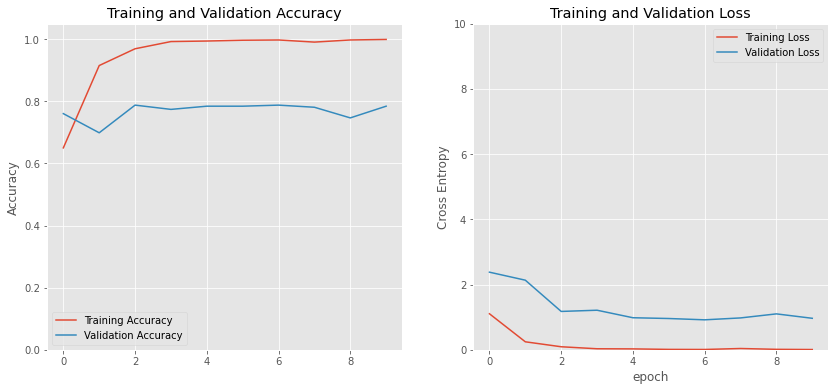

                        precision    recall  f1-score   support

                costra       0.80      0.90      0.84       118
multiples_enfermedades       1.00      0.06      0.11        18
                 oxido       0.83      0.77      0.80       124
             saludable       0.72      0.80      0.76       103

              accuracy                           0.79       363
             macro avg       0.84      0.63      0.63       363
          weighted avg       0.80      0.79      0.77       363



In [23]:
Plot_training_performance(H_preTrained_vgg16, epochs, pathTeacher_img+'/vgg16_1')
Show_classification_report(VGG16_preTrainedModel,testX, testY, 32)

## VGG19

In [12]:
VGG19_baseModel = VGG19(weights='imagenet', include_top=False, input_shape=(192,192,3))
VGG19_baseModel.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 192, 192, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 192, 192, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 192, 192, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 96, 96, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 96, 96, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 96, 96, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 48, 48, 128)       0     

In [16]:
# Creando el top model y congelando TODAS las capas convolucionales (TRANSFER LEARNING)
VGG19_baseModel.trainable = False # Evitar que los pesos se modifiquen en la parte convolucional -> TRANSFER LEARNING
VGG19_preTrainedModel = Sequential()
VGG19_preTrainedModel.add(VGG19_baseModel)
VGG19_preTrainedModel.add(layers.Flatten())
VGG19_preTrainedModel.add(layers.Dense(1024, activation='relu'))
VGG19_preTrainedModel.add(BatchNormalization())
VGG19_preTrainedModel.add(Dropout(0.3))  
VGG19_preTrainedModel.add(layers.Dense(512, activation='relu'))
VGG19_preTrainedModel.add(BatchNormalization())
VGG19_preTrainedModel.add(Dropout(0.3))
VGG19_preTrainedModel.add(layers.Dense(4, activation='softmax'))

VGG19_preTrainedModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 6, 6, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              18875392  
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2

In [17]:
epochs=10

# Compilar el modelo
print("[INFO]: Compilando el modelo...")
VGG19_preTrainedModel.compile(loss="categorical_crossentropy", 
                          optimizer=Adam(learning_rate=0.001),
                          metrics=["accuracy"]) 

#Callbacks
model_cp = ModelCheckpoint(pathTeacher_models+"TL_FT/vgg19_TL_1.h5", monitor='val_loss', verbose=0, save_best_only=True, 
                           save_weights_only=False, mode='auto', save_freq='epoch')
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)  
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, verbose=1)

callbacks_list = [model_cp, early_stop, reduce_lr]  

# Entrenamiento de la red
print("[INFO]: Entrenando la red...")
H_preTrained_vgg19=VGG19_preTrainedModel.fit(trainX, trainY, batch_size=64, epochs=epochs,         
                                             validation_split = 0.2)

[INFO]: Compilando el modelo...
[INFO]: Entrenando la red...
Epoch 1/10
19/19 [==============================] - 69s 4s/step - loss: 1.4931 - accuracy: 0.5515 - val_loss: 3.9239 - val_accuracy: 0.5651
Epoch 2/10
19/19 [==============================] - 67s 4s/step - loss: 0.3493 - accuracy: 0.8808 - val_loss: 2.2485 - val_accuracy: 0.6747
Epoch 3/10
19/19 [==============================] - 67s 4s/step - loss: 0.0947 - accuracy: 0.9700 - val_loss: 1.8047 - val_accuracy: 0.6781
Epoch 4/10
19/19 [==============================] - 67s 4s/step - loss: 0.0505 - accuracy: 0.9889 - val_loss: 1.5920 - val_accuracy: 0.6952
Epoch 5/10
19/19 [==============================] - 69s 4s/step - loss: 0.0471 - accuracy: 0.9863 - val_loss: 1.4740 - val_accuracy: 0.7089
Epoch 6/10
19/19 [==============================] - 69s 4s/step - loss: 0.0224 - accuracy: 0.9966 - val_loss: 1.4215 - val_accuracy: 0.7123
Epoch 7/10
19/19 [==============================] - 68s 4s/step - loss: 0.0243 - accuracy: 0.9923 -

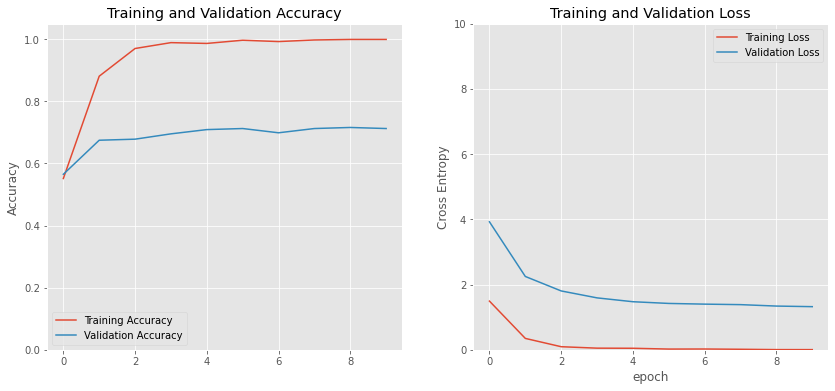

                        precision    recall  f1-score   support

                costra       0.72      0.77      0.74       118
multiples_enfermedades       0.00      0.00      0.00        18
                 oxido       0.69      0.74      0.71       124
             saludable       0.71      0.68      0.70       103

              accuracy                           0.70       363
             macro avg       0.53      0.55      0.54       363
          weighted avg       0.67      0.70      0.68       363



In [18]:
Plot_training_performance(H_preTrained_vgg19, epochs, pathTeacher_img+'/vgg19_1')
# pruebas con datos de Test
Show_classification_report(VGG19_preTrainedModel,testX, testY, 192)

## ResNet50

In [37]:
rn50_baseModel = ResNet50(weights='imagenet', include_top=False, input_shape=(192,192,3))
# rn50_baseModel.summary()

In [38]:
# Creando el top model y congelando TODAS las capas convolucionales (TRANSFER LEARNING)
rn50_baseModel.trainable = False # Evitar que los pesos se modifiquen en la parte convolucional -> TRANSFER LEARNING
rn50_preTrainedModel = Sequential()
rn50_preTrainedModel.add(rn50_baseModel)
rn50_preTrainedModel.add(layers.Flatten())
# rn50_preTrainedModel.add(layers.Dense(1024, activation='relu', kernel_regularizer=l2(0.01)))
rn50_preTrainedModel.add(layers.Dense(1024, activation='relu'))
rn50_preTrainedModel.add(BatchNormalization())
rn50_preTrainedModel.add(Dropout(0.3))  
rn50_preTrainedModel.add(layers.Dense(512, activation='relu'))
rn50_preTrainedModel.add(BatchNormalization())
rn50_preTrainedModel.add(Dropout(0.3))
rn50_preTrainedModel.add(layers.Dense(4, activation='softmax'))

rn50_preTrainedModel.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 6, 6, 2048)        23587712  
_________________________________________________________________
flatten_7 (Flatten)          (None, 73728)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              75498496  
_________________________________________________________________
batch_normalization_14 (Batc (None, 1024)              4096      
_________________________________________________________________
dropout_14 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               524800    
_________________________________________________________________
batch_normalization_15 (Batc (None, 512)              

In [39]:
epochs=20

# Compilar el modelo
print("[INFO]: Compilando el modelo...")
rn50_preTrainedModel.compile(loss="categorical_crossentropy", 
                          optimizer=Adam(learning_rate=0.001),
                          metrics=["accuracy"]) 

#Callbacks
model_cp = ModelCheckpoint(pathTeacher_models+"rn50_TL_1.h5", monitor='val_loss', verbose=0, save_best_only=True, 
                           save_weights_only=False, mode='auto', save_freq='epoch')
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)  
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, verbose=1)

callbacks_list = [model_cp, early_stop, reduce_lr]

# Entrenamiento de la red
print("[INFO]: Entrenando la red...")
H_preTrained_rn50=rn50_preTrainedModel.fit(trainX, trainY, batch_size=8, epochs=epochs,         
                                             validation_split = 0.2, callbacks=callbacks_list)

[INFO]: Compilando el modelo...
[INFO]: Entrenando la red...
Epoch 1/20
146/146 [==============================] - 85s 561ms/step - loss: 1.3644 - accuracy: 0.5935 - val_loss: 1.0408 - val_accuracy: 0.7055


C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/20
146/146 [==============================] - 83s 568ms/step - loss: 0.6454 - accuracy: 0.7890 - val_loss: 1.0832 - val_accuracy: 0.7123
Epoch 3/20
146/146 [==============================] - 83s 570ms/step - loss: 0.3727 - accuracy: 0.8654 - val_loss: 0.8838 - val_accuracy: 0.7363
Epoch 4/20
146/146 [==============================] - 84s 574ms/step - loss: 0.2334 - accuracy: 0.9142 - val_loss: 1.0305 - val_accuracy: 0.7534
Epoch 5/20
146/146 [==============================] - 84s 574ms/step - loss: 0.1902 - accuracy: 0.9408 - val_loss: 1.0796 - val_accuracy: 0.7089
Epoch 6/20
146/146 [==============================] - 84s 573ms/step - loss: 0.1818 - accuracy: 0.9374 - val_loss: 0.9646 - val_accuracy: 0.7158
Epoch 7/20
146/146 [==============================] - 84s 576ms/step - loss: 0.1840 - accuracy: 0.9322 - val_loss: 1.0570 - val_accuracy: 0.7568
Epoch 8/20
146/146 [==============================] - 84s 575ms/step - loss: 0.1891 - accuracy: 0.9340 - val_loss: 1.1146 - val_ac

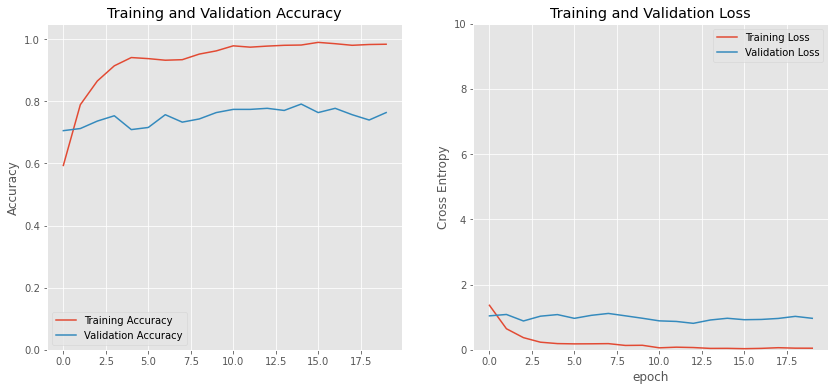

                        precision    recall  f1-score   support

                costra       0.74      0.87      0.80       118
multiples_enfermedades       0.33      0.06      0.10        18
                 oxido       0.78      0.75      0.77       124
             saludable       0.77      0.76      0.76       103

              accuracy                           0.76       363
             macro avg       0.66      0.61      0.61       363
          weighted avg       0.74      0.76      0.74       363



In [40]:
Plot_training_performance(H_preTrained_rn50, epochs, pathTeacher_img+'/rn50_1')
# pruebas con datos de Test
Show_classification_report(rn50_preTrainedModel,testX, testY, 192)

# Fine Tunning

## VGG16

### 4 bloques congelados

In [8]:
# Congelamos las capas de los 4 primeros bloques convolucionales, el quinto se re-entrena
for layer in VGG16_baseModel.layers: 
    if layer.name == 'block5_conv1': 
        break 
    layer.trainable = False 
    print('Capa ' + layer.name + ' congelada...') 

# Cogemos la última capa del model y le añadimos nuestro clasificador (top_model)
last = VGG16_baseModel.layers[-1].output 
x = Flatten()(last) 
x = Dense(1024, activation='relu', name='fc1')(x)
x = BatchNormalization()(x) 
x = Dropout(0.3)(x) 
x = Dense(512, activation='relu', name='fc2')(x)
x = BatchNormalization()(x) 
x = Dropout(0.3)(x) 
x = Dense(4, activation='softmax', name='predictions')(x) 
VGG16_FT_model = Model(VGG16_baseModel.input, x) 

VGG16_FT_model.summary()

Capa input_1 congelada...
Capa block1_conv1 congelada...
Capa block1_conv2 congelada...
Capa block1_pool congelada...
Capa block2_conv1 congelada...
Capa block2_conv2 congelada...
Capa block2_pool congelada...
Capa block3_conv1 congelada...
Capa block3_conv2 congelada...
Capa block3_conv3 congelada...
Capa block3_pool congelada...
Capa block4_conv1 congelada...
Capa block4_conv2 congelada...
Capa block4_conv3 congelada...
Capa block4_pool congelada...
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 192, 192, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 192, 192, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 192, 192, 64)      36928     
_________________________________________________________________
b

In [9]:
epochs=20

# Compilar el modelo
print("[INFO]: Compilando el modelo...")
VGG16_FT_model.compile(loss="categorical_crossentropy", 
                          optimizer=Adam(learning_rate=0.001),
                          metrics=["accuracy"]) 

#Callbacks
model_cp = ModelCheckpoint(pathTeacher_models+"TL_FT/vgg16_FT_1.h5", monitor='val_loss', verbose=0, save_best_only=True, 
                           save_weights_only=False, mode='auto', save_freq='epoch')
early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1)  
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, verbose=1)

callbacks_list = [model_cp, early_stop, reduce_lr]

# Entrenamiento de la red
print("[INFO]: Entrenando la red...")
H_FT_vgg16=VGG16_FT_model.fit(trainX, trainY, batch_size=8, epochs=epochs,         
                             validation_split = 0.2, callbacks=callbacks_list)

[INFO]: Compilando el modelo...
[INFO]: Entrenando la red...
Epoch 1/20
146/146 [==============================] - 86s 579ms/step - loss: 1.5881 - accuracy: 0.4434 - val_loss: 4.3177 - val_accuracy: 0.4418
Epoch 2/20
146/146 [==============================] - 85s 582ms/step - loss: 1.0410 - accuracy: 0.6003 - val_loss: 38.4991 - val_accuracy: 0.0959
Epoch 3/20
146/146 [==============================] - 86s 588ms/step - loss: 0.9306 - accuracy: 0.6630 - val_loss: 1.4957 - val_accuracy: 0.7123
Epoch 4/20
146/146 [==============================] - 86s 591ms/step - loss: 0.7670 - accuracy: 0.7393 - val_loss: 1.9285 - val_accuracy: 0.4521
Epoch 5/20
146/146 [==============================] - 84s 578ms/step - loss: 0.6534 - accuracy: 0.7899 - val_loss: 1.0274 - val_accuracy: 0.7808
Epoch 6/20
146/146 [==============================] - 84s 573ms/step - loss: 0.6653 - accuracy: 0.7804 - val_loss: 1.1165 - val_accuracy: 0.7500
Epoch 7/20
146/146 [==============================] - 85s 580ms/step

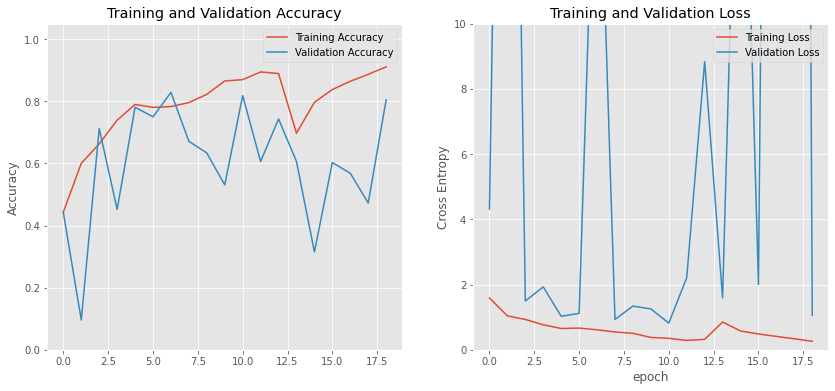

In [10]:
Plot_training_performance(H_FT_vgg16, 19, pathTeacher_img+'/vgg16_FT_1')

In [11]:
# pruebas con datos de Test
Show_classification_report(VGG16_FT_model,testX, testY, 8)

                        precision    recall  f1-score   support

                costra       0.78      0.92      0.84       118
multiples_enfermedades       0.29      0.11      0.16        18
                 oxido       0.94      0.66      0.78       124
             saludable       0.71      0.89      0.79       103

              accuracy                           0.78       363
             macro avg       0.68      0.65      0.64       363
          weighted avg       0.79      0.78      0.77       363



### 3 bloques congelados

In [17]:
# Congelamos las capas de los 3 primeros bloques convolucionales, el quinto se re-entrena
for layer in VGG16_baseModel.layers: 
    if layer.name == 'block4_conv1': 
        break 
    layer.trainable = False 
#     print('Capa ' + layer.name + ' congelada...') 

# Cogemos la última capa del model y le añadimos nuestro clasificador (top_model)
last = VGG16_baseModel.layers[-1].output 
x = Flatten()(last) 
x = Dense(1024, activation='relu', name='fc1', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x) 
x = Dropout(0.3)(x) 
x = Dense(512, activation='relu', name='fc2', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x) 
x = Dropout(0.3)(x) 
x = Dense(4, activation='softmax', name='predictions')(x) 
VGG16_FT_model = Model(VGG16_baseModel.input, x) 

epochs=20

# Compilar el modelo
print("[INFO]: Compilando el modelo...")
VGG16_FT_model.compile(loss="categorical_crossentropy", 
                          optimizer=Adam(learning_rate=0.001),
                          metrics=["accuracy"]) 

#Callbacks
model_cp = ModelCheckpoint(pathTeacher_models+"vgg16_FT_2.h5", monitor='val_loss', verbose=0, save_best_only=True, 
                           save_weights_only=False, mode='auto', save_freq='epoch')
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)  
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, verbose=1)

callbacks_list = [model_cp, early_stop, reduce_lr]

# Entrenamiento de la red
print("[INFO]: Entrenando la red...")
H_FT_vgg16=VGG16_FT_model.fit(trainX, trainY, batch_size=8, epochs=epochs,         
                             validation_split = 0.2, callbacks=callbacks_list)

[INFO]: Compilando el modelo...
[INFO]: Entrenando la red...
Epoch 1/20
146/146 [==============================] - 93s 633ms/step - loss: 7.6789 - accuracy: 0.7513 - val_loss: 6.5983 - val_accuracy: 0.5548
Epoch 2/20
146/146 [==============================] - 91s 625ms/step - loss: 4.2070 - accuracy: 0.7907 - val_loss: 3.6208 - val_accuracy: 0.7979
Epoch 3/20
146/146 [==============================] - 91s 627ms/step - loss: 2.6071 - accuracy: 0.8328 - val_loss: 2.4077 - val_accuracy: 0.8014
Epoch 4/20
146/146 [==============================] - 92s 628ms/step - loss: 2.2021 - accuracy: 0.7153 - val_loss: 6.0515 - val_accuracy: 0.3562
Epoch 5/20
146/146 [==============================] - 91s 624ms/step - loss: 1.5823 - accuracy: 0.8105 - val_loss: 2.1502 - val_accuracy: 0.6062
Epoch 6/20
146/146 [==============================] - 91s 622ms/step - loss: 1.3303 - accuracy: 0.8388 - val_loss: 4.4679 - val_accuracy: 0.3151
Epoch 7/20
146/146 [==============================] - 92s 629ms/step 

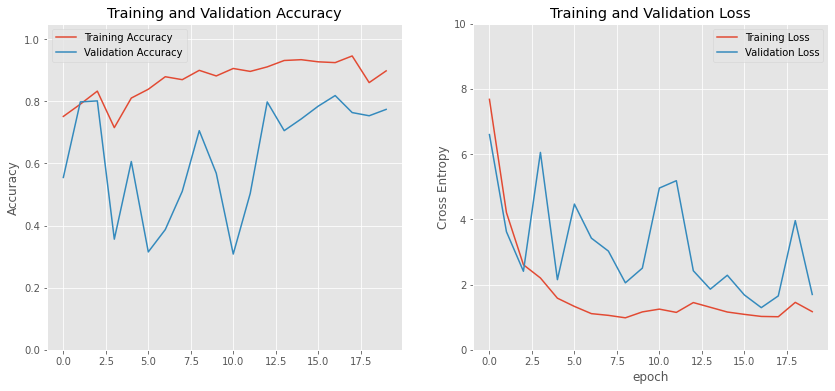

                        precision    recall  f1-score   support

                costra       0.79      0.91      0.84       118
multiples_enfermedades       0.00      0.00      0.00        18
                 oxido       0.96      0.60      0.74       124
             saludable       0.63      0.91      0.74       103

              accuracy                           0.76       363
             macro avg       0.59      0.60      0.58       363
          weighted avg       0.76      0.76      0.74       363



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
Plot_training_performance(H_FT_vgg16, epochs, pathTeacher_img+'/vgg16_FT_2')
# pruebas con datos de Test
Show_classification_report(VGG16_FT_model,testX, testY, 192)

### 2 bloques congelados

In [19]:
# Congelamos las capas de los 3 primeros bloques convolucionales, el quinto se re-entrena
for layer in VGG16_baseModel.layers: 
    if layer.name == 'block3_conv1': 
        break 
    layer.trainable = False 
#     print('Capa ' + layer.name + ' congelada...') 

# Cogemos la última capa del model y le añadimos nuestro clasificador (top_model)
last = VGG16_baseModel.layers[-1].output 
x = Flatten()(last) 
x = Dense(1024, activation='relu', name='fc1', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x) 
x = Dropout(0.3)(x) 
x = Dense(512, activation='relu', name='fc2', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x) 
x = Dropout(0.3)(x) 
x = Dense(4, activation='softmax', name='predictions')(x) 
VGG16_FT_model = Model(VGG16_baseModel.input, x) 

# VGG16_FT_model.summary()

epochs=20

# Compilar el modelo
print("[INFO]: Compilando el modelo...")
VGG16_FT_model.compile(loss="categorical_crossentropy", 
                          optimizer=Adam(learning_rate=0.001),
                          metrics=["accuracy"]) 

#Callbacks
model_cp = ModelCheckpoint(pathTeacher_models+"vgg16_FT_3.h5", monitor='val_loss', verbose=0, save_best_only=True, 
                           save_weights_only=False, mode='auto', save_freq='epoch')
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)  
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, verbose=1)

callbacks_list = [model_cp, early_stop, reduce_lr]

# Entrenamiento de la red
print("[INFO]: Entrenando la red...")
H_FT_vgg16=VGG16_FT_model.fit(trainX, trainY, batch_size=8, epochs=epochs,         
                             validation_split = 0.2, callbacks=callbacks_list)

[INFO]: Compilando el modelo...
[INFO]: Entrenando la red...
Epoch 1/20
146/146 [==============================] - 95s 645ms/step - loss: 6.1553 - accuracy: 0.8233 - val_loss: 4.8293 - val_accuracy: 0.6473
Epoch 2/20
146/146 [==============================] - 92s 631ms/step - loss: 2.6910 - accuracy: 0.9082 - val_loss: 2.7980 - val_accuracy: 0.7705
Epoch 3/20
146/146 [==============================] - 92s 628ms/step - loss: 1.5667 - accuracy: 0.9383 - val_loss: 2.3951 - val_accuracy: 0.7740
Epoch 4/20
146/146 [==============================] - 94s 646ms/step - loss: 1.2099 - accuracy: 0.9185 - val_loss: 1.6509 - val_accuracy: 0.7740
Epoch 5/20
146/146 [==============================] - 92s 633ms/step - loss: 0.8359 - accuracy: 0.9614 - val_loss: 1.7572 - val_accuracy: 0.7740
Epoch 6/20
146/146 [==============================] - 93s 641ms/step - loss: 0.8377 - accuracy: 0.9391 - val_loss: 1.5373 - val_accuracy: 0.7842
Epoch 7/20
146/146 [==============================] - 94s 646ms/step 

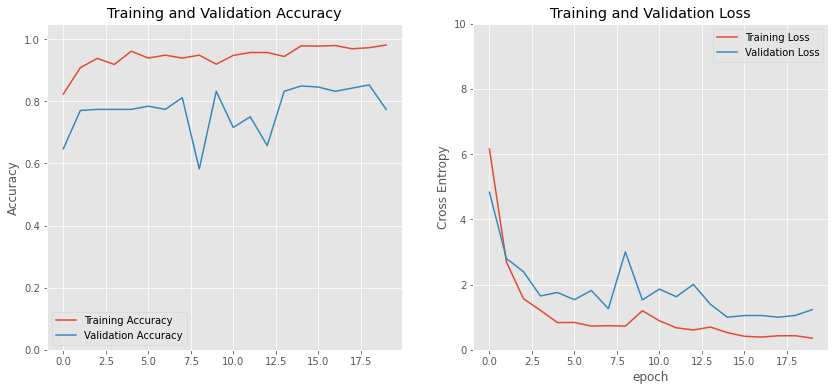

                        precision    recall  f1-score   support

                costra       0.90      0.86      0.88       118
multiples_enfermedades       0.11      0.06      0.07        18
                 oxido       0.70      0.94      0.80       124
             saludable       0.87      0.64      0.74       103

              accuracy                           0.78       363
             macro avg       0.65      0.62      0.62       363
          weighted avg       0.78      0.78      0.77       363



In [21]:
Plot_training_performance(H_FT_vgg16, epochs, pathTeacher_img+'/vgg16_FT_3')
# pruebas con datos de Test
Show_classification_report(VGG16_FT_model,testX, testY, 192)